In [4]:
from modeling.modeling_utils import *

In [3]:
cd ..

/home/x1112373/clinicalBERT/CS598-project


In [5]:
import os
ROOT_PATH = '/home/x1112373/clinicalBERT/CS598-project/custom_bertseqcls_BATCH_SIZE_32_MAX_LEGNTH_512'
dir_list = os.listdir(ROOT_PATH)

In [6]:
experiment_list = sorted(list(filter(lambda x: ('eval_results' in x), dir_list)))

In [7]:
result_list = []
for experiment in experiment_list:
    f = open(ROOT_PATH + '/' + experiment, "r")
    get_result = f.readlines()
    result_dict = {}
    for res in get_result:    
        
        key = res.split('=')[0].strip()
        value = round(float(res.split('=')[1].split('\n')[0].strip()), 3)
        result_dict[key] = value
    learning_rate = experiment.split('_')[4]
    gradient_accumulate = experiment.split('_')[7]
    max_grad_norm = experiment.split('_')[-1].split('.')[0]
    result_dict['learning_rate'] = learning_rate
    result_dict['gradient_accumulate'] = gradient_accumulate
    result_dict['max_grad_norm'] = max_grad_norm
    result_dict['model_path'] = experiment
    result_list.append(result_dict)

In [49]:
pd.DataFrame(result_list).sort_values(by='AUROC')[::-1].to_csv("/home/x1112373/clinicalBERT/CS598-project/evaluation/result.csv", index=False)

In [9]:
cd modeling/

/home/x1112373/clinicalBERT/CS598-project/modeling


In [10]:
from modeling.modeling_utils import *
processors = {
        "readmission": readmissionProcessor
    }
processor = processors['readmission']()
label_list = processor.get_labels()
dev_example = processor.get_dev_examples('/home/x1112373/clinicalBERT/data/3days/')
test_example = processor.get_test_examples('/home/x1112373/clinicalBERT/data/3days/')
test_2_example = processor.get_test_examples('/home/x1112373/clinicalBERT/data/2days/')
labels = set(label_list)
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)
print(len(test_example))

{'0': 0, '1': 1}
5441


In [11]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
BERT_MODEL = "pretraining"
proxies = {'http': 'http://10.40.84.229:10203', 'https': 'http://10.40.84.229:10203'}
#tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='/home/x1112373/clinicalBERT/BioClinicalBERT_Tokenizer')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 
#model = AutoModel.from_pretrained(BERT_MODEL)

In [29]:
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32
EVAL_BATCH = 2
dev_features = convert_examples_to_features(
        dev_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_features(
        test_example, label_list, MAX_SEQ_LENGTH, tokenizer)
test_2days_features = convert_examples_to_features(
        test_2_example, label_list, MAX_SEQ_LENGTH, tokenizer)

04/15/2022 17:45:31 - INFO - modeling.modeling_utils -   *** Example ***
04/15/2022 17:45:31 - INFO - modeling.modeling_utils -   guid: val-0
04/15/2022 17:45:31 - INFO - modeling.modeling_utils -   tokens: [CLS] 10 : 11 pm chest ( pre - op pa & la ##t ) clip # reason : corona ##ry artery disease admitting diagnosis : corona ##ry artery disease medical condition : 77 year old woman with reason for this examination : pre - op final report indication : 77 year old pre - op for cab ##g . technique : pa and lateral radio ##graphs . comparison : findings : the heart is enlarged . there are bilateral pl ##eur ##al e ##ff ##usions , right greater than left with associated minor ate ##le ##cta ##tic changes at the lung bases . the pulmonary va ##scu ##lat ##ure appears somewhat prominent with an upper zone redistribution . there is no p ##ne ##um ##otho ##ra ##x . the patient has had a prior cab ##g with unchanged appearance of median stern ##oto ##my wires . surgical clips are also seen overl

Max Sequence Length: 869


In [13]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)
test_2days_dataloader = get_data_loader(test_2days_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

 

In [30]:
dev_loader = get_data_loader(dev_features, MAX_SEQ_LENGTH, EVAL_BATCH, shuffle=False)

In [15]:
from bert_utils import BertForSequenceClassification
device = 'cuda:2'
model = BertForSequenceClassification.from_pretrained('/home/x1112373/clinicalBERT/CS598-project/pretraining', 1)

04/15/2022 15:06:39 - INFO - bert_utils -   loading archive file /home/x1112373/clinicalBERT/CS598-project/pretraining
04/15/2022 15:06:39 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



in the modeling class


In [14]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('/home/x1112373/clinicalBERT/CS598-project/pretraining', 1)
m = nn.Sigmoid()

In [115]:

model.eval()
correct = 0
eval_loss = 0
eval_accuracy = 0
nb_eval_steps = 0
nb_eval_examples = 0
pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                        token_type_ids=segment_ids, labels=label_ids)
        logits = model(input_ids,segment_ids,input_mask) # we don't need twice

    logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
    label_ids = np.array(np.array(label_ids.to('cpu')))
    outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
    tmp_eval_accuracy=np.sum(outputs == label_ids)


    pred_labels += list(outputs)
    true_labels += list(label_ids)
    logits_history = logits_history + logits.flatten().tolist()
    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps 
eval_accuracy = eval_accuracy / nb_eval_examples
print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')

Evaluation iteration: 100%|██████████| 2721/2721 [02:24<00:00, 18.87it/s]

Epoch: 002, Train loss: 0.6896, Test loss: 0.5867


### Result with pretraining model for test Performance

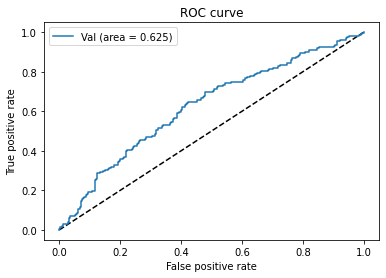

accuracy
0.5866568645469583


<Figure size 432x288 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/test.csv')
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
print('accuracy') 
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])

Recall at Precision of 80 is {} 0.015209125475285171


0.015209125475285171

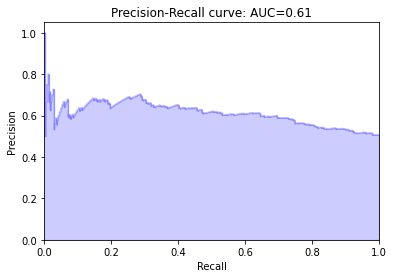

In [121]:
vote_pr_curve(df_test, logits_history, 'tmp')

In [57]:
model_path_list = sorted(list(filter(lambda x: ('LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3' in x), dir_list)))
model_path_list

['clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_0.bin',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_0.pt',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_1.bin',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_2.bin',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_3.bin',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_4.bin',
 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_5.bin',
 'eval_results_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3.txt',
 'logits_clinicalbert_readmission_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_chunks.csv',
 'logits_clinicalbert_readmission_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3_readmissions.csv']

## check for best result 
- LEARNING_RATE : 2e-05
- GRADIENT_ACCUMULATE : X
- MAX_GRAD_NORM : 3

## check belows
- dev set
- 3days test set
- 2days test set

Evaluation iteration: 100%|██████████| 2887/2887 [02:33<00:00, 18.85it/s]


Epoch: 002, Train loss: 0.6928, Test loss: 0.5171


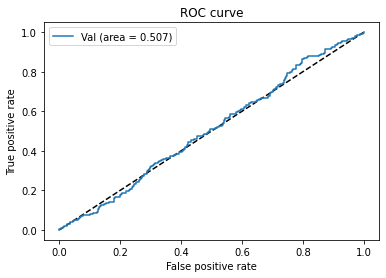

accuracy
0.5171458261170766
Recall at Precision of 80 is {} 0.003484320557491289


Evaluation iteration: 100%|██████████| 2887/2887 [02:33<00:00, 18.83it/s]


Epoch: 002, Train loss: 0.6921, Test loss: 0.4910


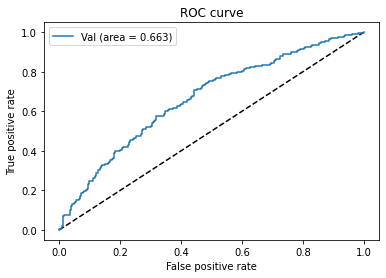

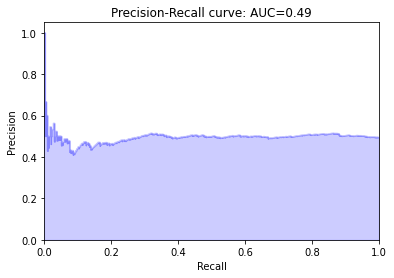

accuracy
0.4909941115344648
Recall at Precision of 80 is {} 0.07317073170731707


Evaluation iteration: 100%|██████████| 2887/2887 [02:32<00:00, 18.90it/s]


Epoch: 002, Train loss: 0.6906, Test loss: 0.5042


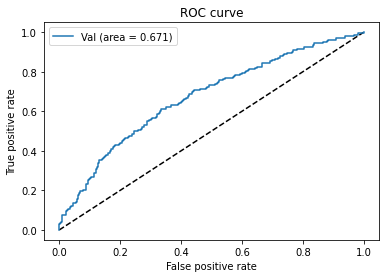

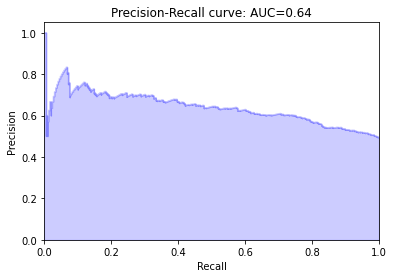

accuracy
0.5041565639071701
Recall at Precision of 80 is {} 0.10104529616724739


<Figure size 432x288 with 0 Axes>

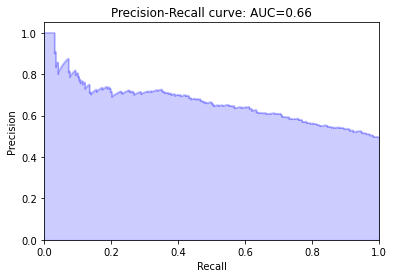

In [58]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(dev_loader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/val.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')

Evaluation iteration: 100%|██████████| 2721/2721 [02:23<00:00, 18.98it/s]


Epoch: 002, Train loss: 0.6910, Test loss: 0.5337


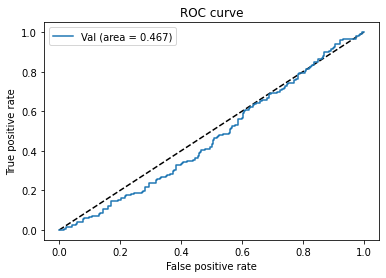

accuracy
0.5337254181216688
Test Sample too small or RP80=0


Evaluation iteration: 100%|██████████| 2721/2721 [02:23<00:00, 18.92it/s]


Epoch: 002, Train loss: 0.6943, Test loss: 0.4703


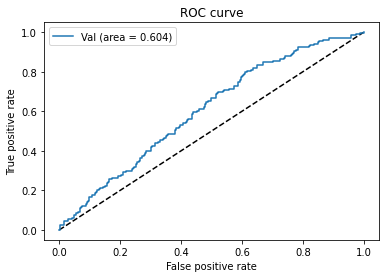

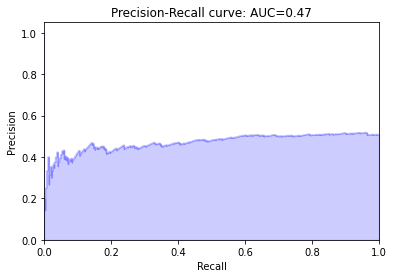

accuracy
0.4703179562580408
Recall at Precision of 80 is {} 0.022813688212927757


Evaluation iteration: 100%|██████████| 2721/2721 [02:23<00:00, 18.93it/s]


Epoch: 002, Train loss: 0.6935, Test loss: 0.4797


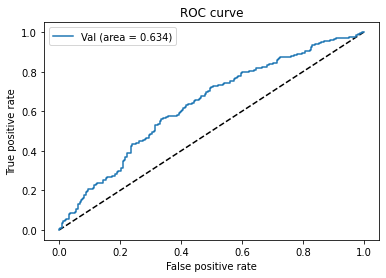

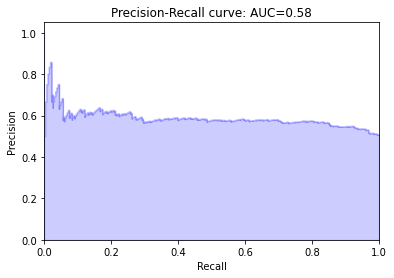

accuracy
0.47969123322918583
Recall at Precision of 80 is {} 0.045627376425855515


<Figure size 432x288 with 0 Axes>

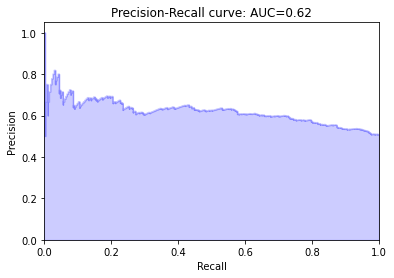

In [60]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/test.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')
    print('-------')

Evaluation iteration: 100%|██████████| 2027/2027 [01:46<00:00, 18.98it/s]


Epoch: 002, Train loss: 0.6898, Test loss: 0.5419


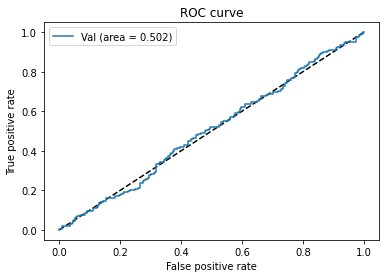

accuracy
0.5419338924518994
Recall at Precision of 80 is {} 0.0036496350364963502
-------


Evaluation iteration: 100%|██████████| 2027/2027 [01:47<00:00, 18.92it/s]


Epoch: 002, Train loss: 0.6943, Test loss: 0.4662


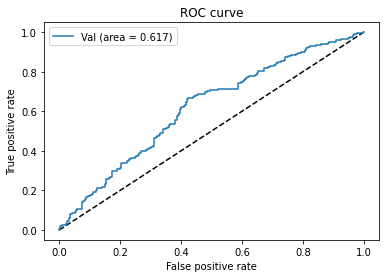

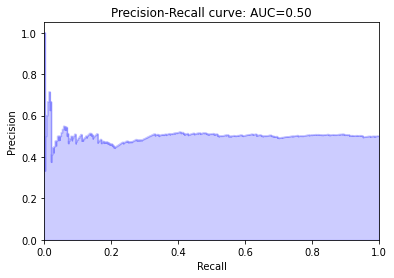

accuracy
0.4662062160828811
Recall at Precision of 80 is {} 0.021897810218978103
-------


Evaluation iteration: 100%|██████████| 2027/2027 [01:47<00:00, 18.90it/s]


Epoch: 002, Train loss: 0.6934, Test loss: 0.4736


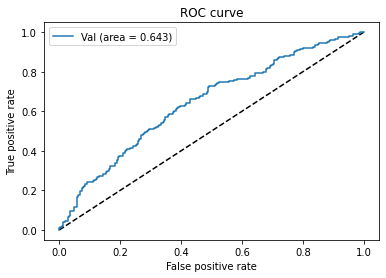

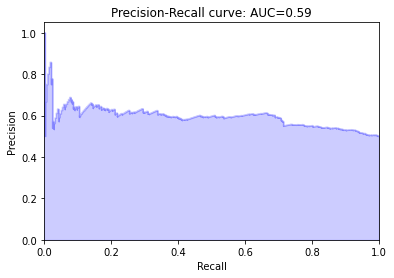

accuracy
0.47360631475086334
Recall at Precision of 80 is {} 0.014598540145985401
-------


<Figure size 432x288 with 0 Axes>

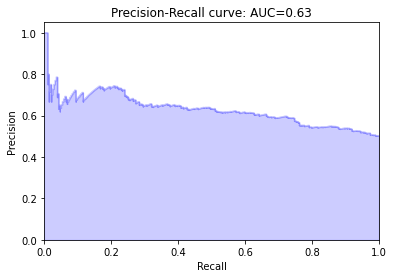

In [61]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_1_MAX_GRAD_NORM_3'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(test_2days_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/2days/test.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')
    print('-------')

Evaluation iteration: 100%|██████████| 2721/2721 [02:23<00:00, 18.92it/s]


Epoch: 002, Train loss: 0.6980, Test loss: 0.4661


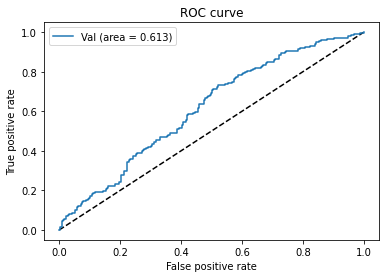

accuracy
0.46609079213379895
Recall at Precision of 80 is {} 0.049429657794676805
-------


Evaluation iteration:  61%|██████    | 1648/2721 [01:27<00:56, 18.94it/s]

In [ ]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_4_MAX_GRAD_NORM_5'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(test_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/test.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')
    print('-------')

In [38]:
best_model = 'clinicalbert_LEARNING_RATE_2e-05_gradient_accu_4_MAX_GRAD_NORM_5'
model_path_list = []
for ep in range(3):
    model_path_list.append(f'{best_model}_{ep}.bin')
    
for selected_model in model_path_list:
    model_path = ROOT_PATH + '/' + selected_model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    correct = 0
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0
    nb_eval_examples = 0
    pred_labels, true_labels, logits_history, pred_scores = [], [], [], []
    model.eval()
    for step, batch in enumerate(tqdm(test_2days_dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, attention_mask=input_mask,
                                            token_type_ids=segment_ids, labels=label_ids)
            logits = model(input_ids,segment_ids,input_mask) # we don't need twice

        logits = torch.squeeze(m(logits)).detach().cpu().numpy() 
        label_ids = np.array(np.array(label_ids.to('cpu')))
        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)


        pred_labels += list(outputs)
        true_labels += list(label_ids)
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps 
    eval_accuracy = eval_accuracy / nb_eval_examples
    print(f'Epoch: {1 + 1:03d}, Train loss: {eval_loss:.4f}, Test loss: {eval_accuracy:.4f}')
    df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/2days/test.csv')
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
    fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
    print('accuracy') 
    print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
    vote_pr_curve(df_test, logits_history, 'tmp')
    print('-------')

Evaluation iteration: 100%|██████████| 2887/2887 [02:33<00:00, 18.76it/s]

Epoch: 002, Train loss: 0.6883, Test loss: 0.5229


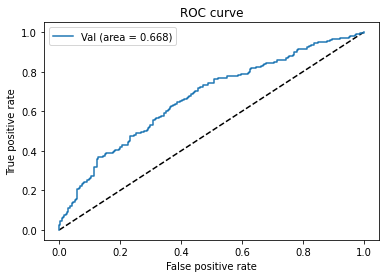

accuracy
0.5228611014894354
Recall at Precision of 80 is {} 0.11149825783972125


0.11149825783972125

<Figure size 432x288 with 0 Axes>

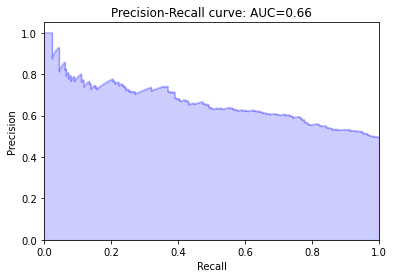

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
df_test = pd.read_csv('/home/x1112373/clinicalBERT/data/3days/val.csv')
df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})
fpr, tpr, df_out, roc_auc = vote_score(df_test, logits_history, 'tmp')
print('accuracy') 
print(df.loc[df.pred_label == df.label].shape[0] / df.shape[0])
vote_pr_curve(df_test, logits_history, 'tmp')